# Imports

In [1]:
# Load data using values set above
from freqtrade.data.history import load_pair_history
from lazyft import paths
import pandas as pd
import numpy as np
from finta import TA as fta
import pandas_ta as pta
import matplotlib.pyplot as plt
import talib.abstract as ta
import freqtrade.vendor.qtpylib.indicators as qtpylib
# import plotly.graph_objects as go
import mplfinance as mpf
from functools import reduce
from freqtrade.resolvers import StrategyResolver
from freqtrade.configuration import Configuration

In [25]:
pair = 'MATIC/USDT'
# Initialize empty configuration object
config = Configuration.from_files(['configs/config_3_100_unlimited_usdt.json'])
datadir = paths.USER_DATA_DIR.joinpath('data', 'kucoin')

stock1 = 'BTC'
stock2 = 'MATIC'
stock3 = 'LTC'
stock1_candles = load_pair_history(datadir=datadir,
                                   timeframe='5m',
                                   pair=f"{stock1}/USDT",
                                   data_format="json",
                                   )

stock2_candles = load_pair_history(datadir=datadir,
                                   timeframe='5m',
                                   pair=f"{stock2}/USDT",
                                   data_format="json",
                                   )
stock3_candles = load_pair_history(datadir=datadir,
                                   timeframe='5m',
                                   pair=f"{stock3}/USDT",
                                   data_format="json",
                                   )
stock1_candles.set_index(stock1_candles.date, inplace=True)
stock2_candles.set_index(stock2_candles.date, inplace=True)
stock3_candles.set_index(stock3_candles.date, inplace=True)
# stock1_candles= stock1_candles.drop('date', axis=1)
# stock2_candles=stock2_candles.drop('date', axis=1)
# Confirm success
print("Loaded " + str(len(stock2_candles)) + f" rows of data for {stock2}/USDT from {datadir}")
# stock2_candles.head()

Loaded 58267 rows of data for MATIC/USDT from /home/sage/ftworkdir/user_data/data/kucoin


,date,open,high,low,close,volume
date,,,,,,
2021-05-13 10:00:00+00:00,2021-05-13 10:00:00+00:00,0.600,1.400,0.600,1.049,154K
2021-05-13 10:05:00+00:00,2021-05-13 10:05:00+00:00,1.049,1.080,1.040,1.060,48.2K
2021-05-13 10:10:00+00:00,2021-05-13 10:10:00+00:00,1.060,1.070,1.043,1.070,113K
2021-05-13 10:15:00+00:00,2021-05-13 10:15:00+00:00,1.070,1.090,1.051,1.080,69.9K
2021-05-13 10:20:00+00:00,2021-05-13 10:20:00+00:00,1.077,1.080,1.052,1.066,43.1K


# Cointegration

In [109]:
def normalize_and_accumulate_series(data: pd.DataFrame, cumsum=True):
    data = data[data.index >= stock2_candles.iloc[0].date]
    if cumsum:
        return data.pct_change().cumsum()
    else:
        return data.pct_change()

# matic_data = stock2_candles.copy()
# matic_data.index = stock2_candles.date
# btc_data = stock1_candles.copy()
# btc_data.index = stock1_candles.date

returns = pd.DataFrame(index=stock2_candles.index)
returns.index = pd.to_datetime(returns.index)
# data = pd.DataFrame(index=stock2_candles.date)
# # data.index = data.set_index(stock2_candles.date)
# data[stock1] = stock1_candles['close']
# data[stock2] = stock2_candles['close']
# merged_data = data.merge(btc_data['close'], left_index=True, right_index=True)
# merged_data = data.merge(matic_data['close'], left_index=True, right_index=True)
# data['btc'] = btc_candles['close']
# data['matic'] = candles['close']
# data.index = btc_candles.date
# btc_diff = np.append(data['btc'][1:].reset_index(drop=True) / data['btc'][:-1].reset_index(drop=True) - 1, 0)
# btc_diff_ma = ta.SMA(btc_diff, timeperiod=2)
# returns['btc'] = btc_diff
# returns['btc1'] = data['btc'] / data['btc'].shift(1)
returns[stock1] = normalize_and_accumulate_series(stock1_candles['close'])

# matic_diff = np.append(data['matic'][1:].reset_index(drop=True) / data['matic'][:-1].reset_index(drop=True) - 1, 0)
# matic_sma = ta.SMA(matic_diff, timeperiod=2)
# returns['matic'] = matic_diff
# returns['matic1'] = data['matic'] / data['matic'].shift(1)
returns[stock2] = normalize_and_accumulate_series(stock2_candles['close'])

# data
# merged_data
returns['diff'] = returns[stock1] - returns[stock2]
returns[stock2 + 'sma9'] = ta.SMA(returns[stock2], timeperiod=9)
returns[stock2 + 'sma25'] = ta.SMA(returns[stock2], timeperiod=25)
# returns['btc_up'] = returns['diff'] > 0
returns = returns.tail(len(returns)-1)
# returns
# data.index
# stock1_candles
returns

,BTC,MATIC,diff,MATICsma9,MATICsma25
date,,,,,
2021-05-14 00:00:00+00:00,0.003,0.394,-0.391,NaN,NaN
2021-05-15 00:00:00+00:00,-0.058,0.478,-0.536,NaN,NaN
2021-05-16 00:00:00+00:00,-0.066,0.560,-0.626,NaN,NaN
2021-05-17 00:00:00+00:00,-0.128,0.563,-0.691,NaN,NaN
2021-05-18 00:00:00+00:00,-0.144,0.976,-1.120,NaN,NaN
...,...,...,...,...,...
2021-10-28 00:00:00+00:00,0.352,1.510,-1.159,1.241,1.082
2021-10-29 00:00:00+00:00,0.379,1.458,-1.079,1.275,1.104
2021-10-30 00:00:00+00:00,0.373,1.384,-1.011,1.303,1.121


In [91]:
# !pip install statsmodels
from statsmodels.tsa.stattools import coint


def corr(data1, data2):
    mean1 = data1.mean()
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()
    corr = ((data1 * data2).mean() - mean1 * mean2) / (std1 / std2)
    return corr


In [105]:
score, pvalue, _ = coint(returns[stock1], returns[stock2])
correlation = corr(returns[stock1], returns[stock2])

print(f'Correlation between {stock1} and {stock2} is {correlation}')
print(f'The cointegration between {stock1} and {stock2} is {pvalue}')
if pvalue < 0.05:
    print('The correlation is statistically significant.')
else:
    print('The correlation is NOT statistically significant.')


Correlation between BTC and MATIC is 0.05380184678823514
The cointegration between BTC and MATIC is 0.11092938610701569
The correlation is NOT statistically significant.


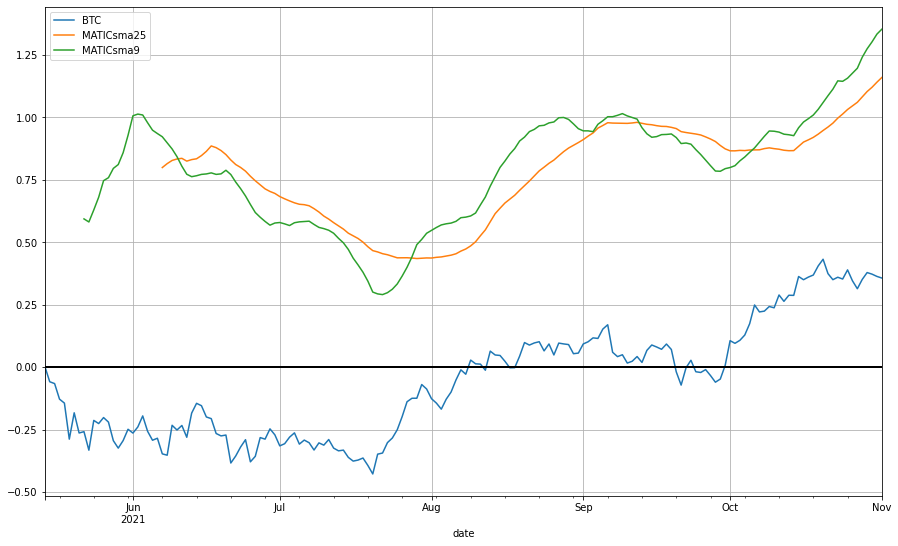

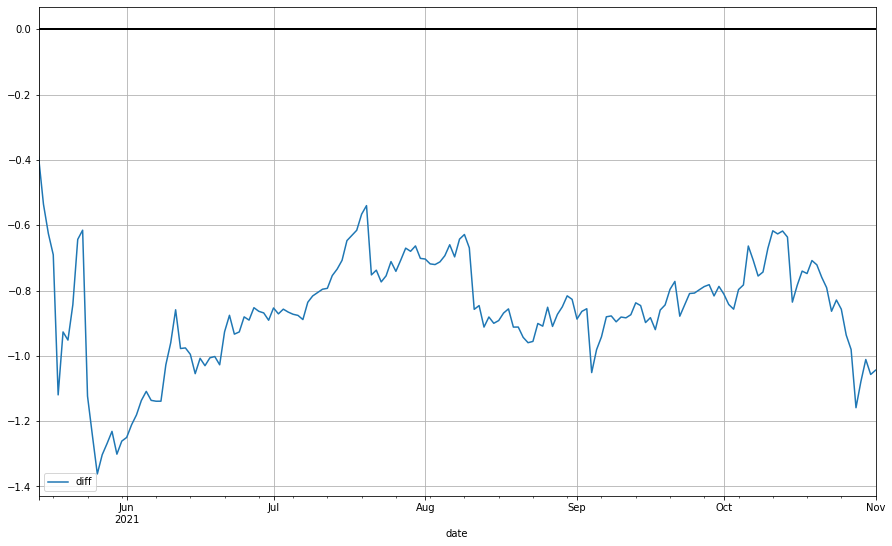

In [110]:
pylab.rcParams['figure.figsize'] = (15, 9)
returns[[stock1, stock2+'sma25', stock2+'sma9']].plot(grid=True, label=f'Percent Change {stock1} & {stock2}').axhline(y=0, color="black", lw=2)
returns[['diff']].plot(grid=True).axhline(y=0, color="black", lw=2)
# plt.ylim(-2, 2)

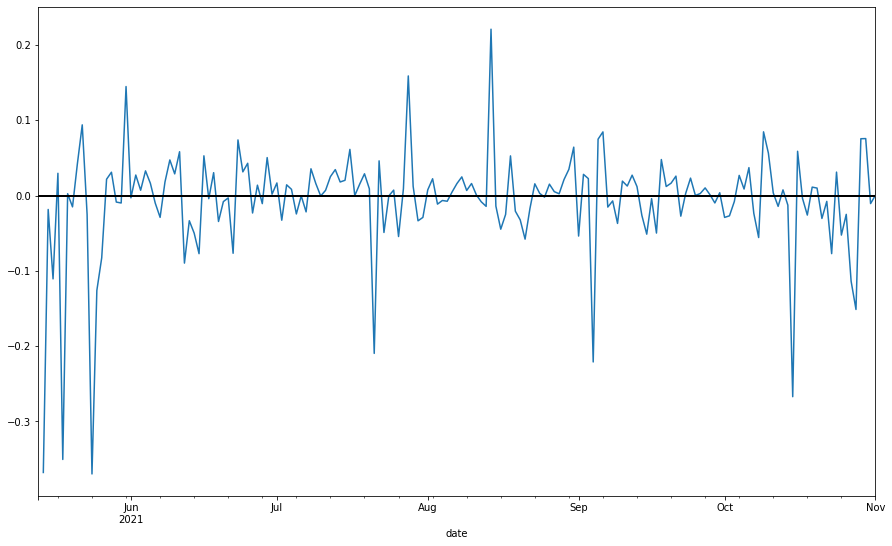

In [46]:
returns['diff'].plot().axhline(y=0, color="black", lw=2)

In [60]:
apdict = mpf.make_addplot(data[['btc', 'matic']])
mpf.plot(data, show_nontrading=True, addplot=apdict)

/home/sage/ftworkdir/.direnv/python-3.9.7/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


KeyError: 'Open'

# Augmented Bollinger Bands

<AxesSubplot:xlabel='date'>

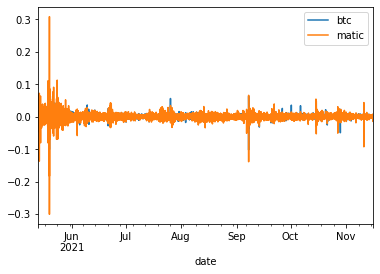

## Implement

In [34]:
std = 2
window = 40
wma_high = fta.WMA(data, window, 'high')
wma_low = fta.WMA(data, window, 'low')
std_high = qtpylib.rolling_std(data['high'], window=window)
std_low = qtpylib.rolling_std(data['low'], window=window)
upper_band = wma_high + (std * std_high)
lower_band = wma_low - (std * std_low)

In [35]:
data['upper'] = upper_band
data['lower'] = lower_band
data['mid'] = fta.WMA(data, 20)

## Graph

/home/sage/ftworkdir/.direnv/python-3.9.7/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


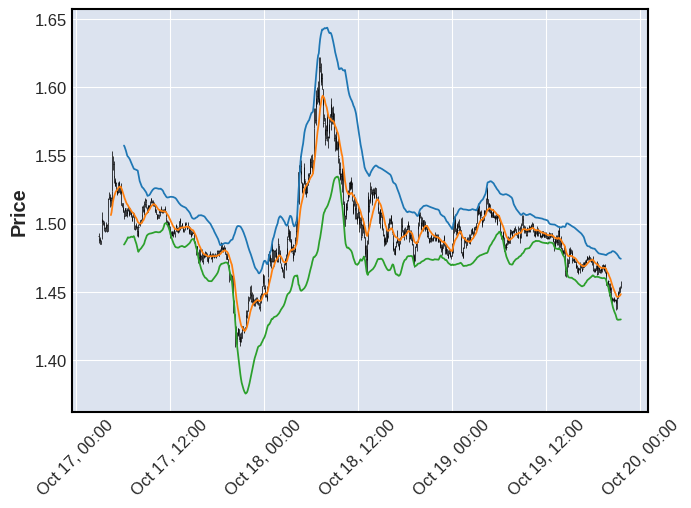

In [36]:

# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

# fig = go.Figure(data=go.Ohlc(x=df['Date'],
#                     open=df['AAPL.Open'],
#                     high=df['AAPL.High'],
#                     low=df['AAPL.Low'],
#                     close=df['AAPL.Close']))
# fig.show()


apdict = mpf.make_addplot(data[['upper', 'mid', 'lower']])
mpf.plot(data, show_nontrading=True, addplot=apdict)

# Fibonacci Moving Average

In [102]:
data = stock2_candles.copy().tail(500)
data.set_index(data.date, inplace=True)

## Implement

In [103]:
fib_list = {5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597}
ema_high_list = []
ema_low_list = []

for f in fib_list:
    ema_high_list.append(fta.EMA(data, f, 'high'))

for f in fib_list:
    ema_low_list.append(fta.EMA(data, f, 'low'))

fib_high = sum(ema_high_list) / len(fib_list)
fib_low = sum(ema_low_list) / len(fib_list)
data['fib_high'] = fib_high
data['fib_low'] = fib_low
data.tail()

,date,open,high,low,close,volume,fib_high,fib_low
date,,,,,,,,
2021-05-15 03:15:00+00:00,2021-05-15 03:15:00+00:00,1.679,1.697,1.657,1.688,84.6K,1.552,1.518
2021-05-15 03:20:00+00:00,2021-05-15 03:20:00+00:00,1.690,1.721,1.688,1.721,55.2K,1.554,1.520
2021-05-15 03:25:00+00:00,2021-05-15 03:25:00+00:00,1.721,1.721,1.694,1.701,75.4K,1.555,1.522
2021-05-15 03:30:00+00:00,2021-05-15 03:30:00+00:00,1.706,1.710,1.683,1.693,47.9K,1.556,1.523
2021-05-15 03:35:00+00:00,2021-05-15 03:35:00+00:00,1.692,1.729,1.680,1.688,91.9K,1.557,1.524


/home/sage/ftworkdir/.direnv/python-3.9.7/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


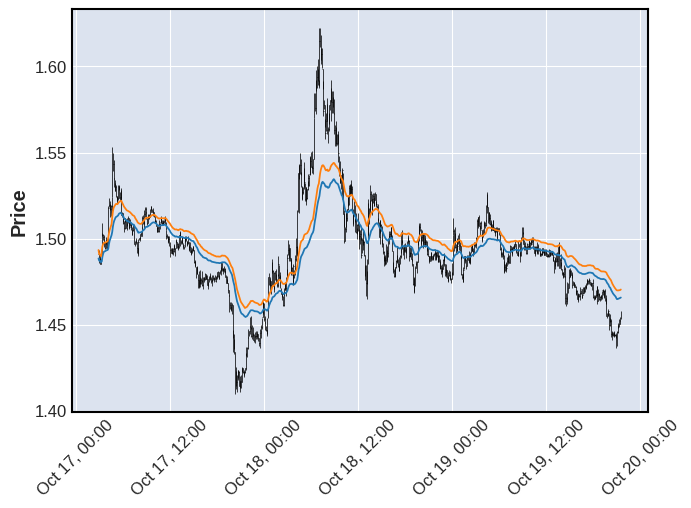

In [46]:
apdict = mpf.make_addplot(data[['fib_low', 'fib_high']])
mpf.plot(data, show_nontrading=True, addplot=apdict)

In [52]:
stock2_candles.head()

,date,open,high,low,close,volume
0,2021-05-13 10:00:00+00:00,0.600,1.400,0.600,1.049,154K
1,2021-05-13 10:05:00+00:00,1.049,1.080,1.040,1.060,48.2K
2,2021-05-13 10:10:00+00:00,1.060,1.070,1.043,1.070,113K
3,2021-05-13 10:15:00+00:00,1.070,1.090,1.051,1.080,69.9K
4,2021-05-13 10:20:00+00:00,1.077,1.080,1.052,1.066,43.1K


# Rob Booker Reversal Indicator

In [19]:
data = stock2_candles.copy().head(5000)
data.set_index(data.date, inplace=True)

## Implement

In [20]:
macd = ta.MACD(data)
data['macd'] = macd['macd']
data['macdsignal'] = macd['macdsignal']
data['macdhist'] = macd['macdhist']
stoch = qtpylib.stoch(data, 70)
stoch_val = (stoch['slow_k'] + stoch['slow_d']) / 2
data['stoch'] = stoch_val
data['stoch_sma10'] = qtpylib.sma(data['stoch'], 10)

## Buy Conditions

In [21]:
conditions = []
conditions.append(
    (qtpylib.crossed_above(data['macd'], data['macdsignal'])) &
    (data['stoch_sma10'] < 30)
)
if conditions:
    data.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = data['close']

## Sell Conditions

In [22]:
conditions = []
conditions.append(
    (qtpylib.crossed_below(data['macd'], data['macdsignal'])) &
    (data['stoch_sma10'] > 70)
)
if conditions:
    data.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = data['close']

In [23]:
data

,date,open,high,low,close,volume,macd,macdsignal,macdhist,stoch,stoch_sma10,buy,sell
date,,,,,,,,,,,,,
2021-05-13 10:00:00+00:00,2021-05-13 10:00:00+00:00,0.600,1.400,0.600,1.049,154K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-13 10:05:00+00:00,2021-05-13 10:05:00+00:00,1.049,1.080,1.040,1.060,48.2K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-13 10:10:00+00:00,2021-05-13 10:10:00+00:00,1.060,1.070,1.043,1.070,113K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-13 10:15:00+00:00,2021-05-13 10:15:00+00:00,1.070,1.090,1.051,1.080,69.9K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-13 10:20:00+00:00,2021-05-13 10:20:00+00:00,1.077,1.080,1.052,1.066,43.1K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30 18:15:00+00:00,2021-05-30 18:15:00+00:00,1.913,1.930,1.913,1.925,89.8K,0.018,0.016,0.002,93.975,69.926,NaN,NaN
2021-05-30 18:20:00+00:00,2021-05-30 18:20:00+00:00,1.926,1.927,1.911,1.913,38.6K,0.018,0.016,0.002,95.264,73.307,NaN,NaN
2021-05-30 18:25:00+00:00,2021-05-30 18:25:00+00:00,1.912,1.926,1.911,1.925,49.9K,0.019,0.017,0.002,94.866,76.967,NaN,NaN


## Graph

/home/sage/ftworkdir/.direnv/python-3.9.7/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


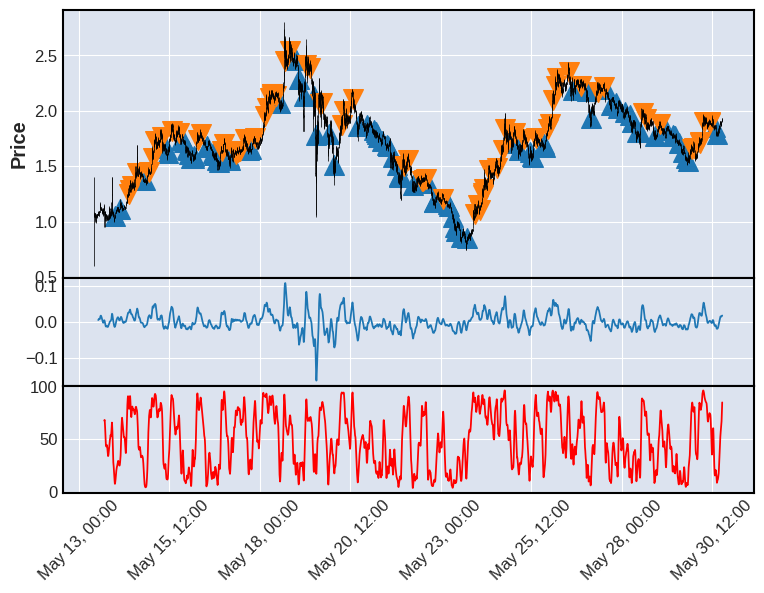

In [24]:
apds = [
    mpf.make_addplot(data['macdsignal'], panel=1),
    mpf.make_addplot(data['stoch_sma10'], panel=2, color='r'),

    mpf.make_addplot(data['buy'], type='scatter', markersize=200, marker='^'),
    mpf.make_addplot(data['sell'], type='scatter', markersize=200, marker='v'),
]
mpf.plot(data, show_nontrading=True, addplot=apds, figscale=1.2)

,date,open,high,low,close,volume,macd,macdsignal,macdhist,stoch,stoch_sma10,buy,sell
0,2021-05-13 10:00:00+00:00,0.600,1.400,0.600,1.049,154K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-13 10:05:00+00:00,1.049,1.080,1.040,1.060,48.2K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-13 10:10:00+00:00,1.060,1.070,1.043,1.070,113K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-05-13 10:15:00+00:00,1.070,1.090,1.051,1.080,69.9K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-13 10:20:00+00:00,1.077,1.080,1.052,1.066,43.1K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45926,2021-10-19 21:10:00+00:00,1.450,1.451,1.448,1.451,8.65K,-0.005,-0.006,0.001,22.381,9.917,NaN,NaN
45927,2021-10-19 21:15:00+00:00,1.451,1.454,1.449,1.450,13.7K,-0.004,-0.005,0.001,29.384,12.071,NaN,NaN
45928,2021-10-19 21:20:00+00:00,1.450,1.453,1.450,1.453,27.8K,-0.003,-0.005,0.002,34.204,14.727,NaN,NaN
45929,2021-10-19 21:25:00+00:00,1.453,1.454,1.452,1.454,36.6K,-0.003,-0.005,0.002,37.430,17.667,NaN,NaN


# MACD

In [155]:
data = stock2_candles.copy().head(5000)
macd = ta.MACD(data)
data['macd'] = macd['macd']
data['macdsignal'] = macd['macdsignal']
data['macdhist'] = macd['macdhist']

4980   165.559
4981   152.288
4982   150.343
4983   146.224
4984    88.730
4985    55.004
4986    18.187
4987   -12.622
4988    23.705
4989   -10.110
4990    35.126
4991    38.366
4992    96.152
4993    93.079
4994   134.723
4995   184.272
4996   125.426
4997   124.321
4998   120.507
4999   117.836
Name: CCI_14_0.015, dtype: float64

In [41]:
df = stock1_candles
df2 = stock2_candles
df3 = stock3_candles
func = ta.CDLGRAVESTONEDOJI
a = pd.Series(func(df['open'], df['high'], df['low'], df['close'])).unique()
b = pd.Series(func(df2['open'], df2['high'], df2['low'], df2['close'])).unique()
c = pd.Series(func(df3['open'], df3['high'], df3['low'], df3['close'])).unique()
print(a, b, c)

[  0 100] [  0 100] [  0 100]
